In [23]:
import qutip as qt
from qutip import Bloch, QobjEvo, basis, sesolve, sigmay, sigmaz, Qobj
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
from scipy.constants import h, e
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.transformers import FreezeCoreTransformer, ActiveSpaceTransformer
# Operadores de Pauli en el qubit k
def SX(N, k):
    """Create a sigma_X operator at position k from
    a Hilbert space of N qubits
    """
    L = [qt.qeye(2)]*N 
    L[k] = qt.sigmax()
    return qt.tensor(L)

def SY(N, k):
    """Create a sigma_Y operator at position k from
    a Hilbert space of N qubits
    """
    L = [qt.qeye(2)]*N
    L[k] = qt.sigmay()
    return qt.tensor(L)

def SZ(N, k):
    """Create a sigma_Z operator at position k from
    a Hilbert space of N qubits
    """
    L = [qt.qeye(2)]*N
    L[k] = qt.sigmaz()
    return qt.tensor(L)


from qutip import create, destroy

def Sm(N, k):
    """Create a sigma_X operator at position k from
    a Hilbert space of N qubits
    """
    L = [qt.qeye(2)]*N 
    L[k] = destroy(2)
    return qt.tensor(L)

def Sp(N, k):
    """Create a sigma_X operator at position k from
    a Hilbert space of N qubits
    """
    L = [qt.qeye(2)]*N 
    L[k] = create(2)
    return qt.tensor(L)



In [24]:
import qutip as qt
import numpy as np

def Rz_qubit(N, k, angle):
    """Aplica una rotación Rz al qubit k en un sistema de N qubits."""
    rz = qt.Qobj([[np.exp(-1j * angle / 2), 0], [0, np.exp(1j * angle / 2)]])
    ops = [qt.qeye(2)] * N
    ops[k] = rz
    return qt.tensor(ops)

def SX_qubit(N, k): # el raiz de X
    """Aplica la raíz de X al qubit k en un sistema de N qubits."""
    sx = qt.Qobj([[0.5*(1+1j), 0.5*(1-1j)], [0.5*(1-1j), 0.5*(1+1j)]])
    ops = [qt.qeye(2)] * N
    ops[k] = sx
    return qt.tensor(ops)

def ECR(N, control, target):
    """
    Create the ECR gate acting on 'control' and 'target' qubits in an N-qubit system.
    Definition used: ECR = (I⊗X - X⊗Y)/sqrt(2)
    """
    term1 = qt.tensor([qt.qeye(2)] * N)
    term2 = qt.tensor([qt.qeye(2)] * N)

    # Term I⊗X
    term1 = qt.qeye(2**N)
    L = [qt.qeye(2)] * N
    L[target] = qt.sigmax()
    term1 = qt.tensor(L)

    # Term X⊗Y
    L = [qt.qeye(2)] * N
    L[control] = qt.sigmax()
    L[target] = qt.sigmay()
    term2 = qt.tensor(L)

    # Final ECR operator
    ECR_gate = (term1 - term2) / np.sqrt(2)
    return ECR_gate

# Ejemplo de uso
N = 2  # Dos qubits
angle = np.pi/2  # Un ángulo de ejemplo

rz_0 = Rz_qubit(N, 0, angle)
sx_1 = SX_qubit(N, 1)
ecr_0_1 = ECR(N, 0, 1)
ecr_1_0 = ECR(N, 1, 0)


def d_FS(psi : Qobj, phi : Qobj) -> Qobj:
    return np.sqrt( 2 - 2 * np.abs(psi.dag() * phi) ) 



In [25]:
s0 = qt.basis(2, 0)
s1 = qt.basis(2, 1)

Bell = (qt.tensor(s0, s0) + qt.tensor(s1, s1)).unit()
Bell2 = (qt.tensor(s0, s1) + qt.tensor(s1, s0)).unit()

psi_i = qt.tensor(s0, s0)  # Estado inicial
psi_f = Bell2  # Estado final
theta = np.arccos(np.real(psi_i.dag() * psi_f))  # Calcula el ángulo entre los dos estados

tau = np.linspace(0, theta, 100)  # Tiempo de evolución

def Gamma(psi_i, psi_f, tau):
    theta = np.arccos(np.real(psi_i.dag() * psi_f)) 
    psi_t = (psi_f - np.cos(theta)*psi_i) / np.sin(theta)
    Psi = np.cos(tau)*psi_i + np.sin(tau)*psi_t 
    return Psi 

# n = 50
# tau = np.linspace(0, theta, n)

In [26]:
n = 3
s0 = qt.basis(2, 0)
s1 = qt.basis(2, 1)

Bell1 = (qt.tensor(s0, s0) + qt.tensor(s1, s1)).unit()
Bell2 = (qt.tensor(s0, s0) - qt.tensor(s1, s1)).unit()
Bell3 = (qt.tensor(s0, s1) + qt.tensor(s1, s0)).unit()
Bell4 = (qt.tensor(s0, s1) - qt.tensor(s1, s0)).unit()

psi_i = qt.tensor(s0, s0)  # Estado inicial
psi_f = Bell1  # Estado final
theta = np.arccos(np.real(psi_i.dag() * psi_f))  # Calcula el ángulo entre los dos estados

tau = np.linspace(0, theta, n)
Gamma_tau = [Gamma(psi_i, psi_f, ti) for ti in tau]
N = 2

OP = [SX_qubit(N, 0), SX_qubit(N, 1), ECR(N, 0, 1), ECR(N, 1, 0), SX(N,0), SX(N,1)] #the last one we shoul call it X only




In [27]:
from scipy.optimize import minimize_scalar
def find_min_distance(psi_i, Gamma_tau_i, N=2):

    distances = []

    # Aplicar cada operador fijo
    for op in OP:
        psi_new = op * psi_i
        overlap = np.clip(np.real((psi_new.dag() * Gamma_tau_i)), -1.0, 1.0)
        theta = np.arccos(overlap)
        distances.append(theta)

    # Ahora agregamos el Rz optimizado
    def objective1(angle):
        rz_op = Rz_qubit(N, 0, angle)  # Por ejemplo, actuando en qubit 0
        psi_new = rz_op * psi_i
        overlap = np.clip(np.real((psi_new.dag() * Gamma_tau_i)), -1.0, 1.0)
        return np.arccos(overlap)
    
    
    def objective2(angle):
        rz_op = Rz_qubit(N, 1, angle)  # Por ejemplo, actuando en qubit 0
        psi_new = rz_op * psi_i
        overlap = np.clip(np.real((psi_new.dag() * Gamma_tau_i)), -1.0, 1.0)
        return np.arccos(overlap)
    
    #result1 = minimize_scalar(objective1, bounds=(0, 2*np.pi), method='bounded')
    #distances.append(result1.fun)
    # OP.append(Rz_qubit(N, 0, result1.x))

    # result2 = minimize_scalar(objective1, bounds=(0, 2*np.pi), method='bounded')
    # distances.append(result2.fun)
    # OP.append(Rz_qubit(N, 1, result2.x))

    min_distance = min(distances)
    min_index = np.argmin(distances)
    
    return min_distance, OP[min_index], min_index

n = 4
theta = np.arccos(np.real(psi_i.dag() * psi_f))  # Calcula el ángulo entre los dos estados

tau = np.linspace(0, theta, n)
Gamma_tau = [Gamma(psi_i, psi_f, ti) for ti in tau]


Psi0 = psi_i
Op_real = []
min_distances= []
index_real = []
for i in range(len(Gamma_tau)-1):
    Geodesic = find_min_distance(Psi0, Gamma_tau[i+1])
    min_distances.append(Geodesic[0])
    index_real.append(Geodesic[2])

    O = Geodesic[1]
    Op_real.append(O)
    Psi0 = O * Psi0

theta_final = np.arccos(np.real(Psi0.dag() * psi_f))
theta_final

2.1073424255447017e-08

In [28]:
Psi0

Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.70710678]]

In [29]:
psi_f

Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.70710678]]

In [30]:
## ADAPT geodesic
N = 2 #numero de qubits
OP = [SX_qubit(N, 0), SX_qubit(N, 1), ECR(N, 0, 1), ECR(N, 1, 0), SX(N,0), SX(N,1)]
n = 2
psi_i = qt.tensor(s0, s0)  # Estado inicial
psi_f = Bell1 # Bell2 no funciona, los otros si
while True:
    
    theta = np.arccos(np.real(psi_i.dag() * psi_f))  # Calcula el ángulo entre los dos estados

    tau = np.linspace(0, theta, n)
    Gamma_tau = [Gamma(psi_i, psi_f, ti) for ti in tau]


    Psi0 = psi_i
    Op_real = []
    min_distances= []
    index_real = []
    for i in range(len(Gamma_tau)-1):
        Geodesic = find_min_distance(Psi0, Gamma_tau[i+1])
        min_distances.append(Geodesic[0])
        index_real.append(Geodesic[2])

        O = Geodesic[1]
        Op_real.append(O)
        Psi0 = O * Psi0

    theta_final = np.arccos(np.real(Psi0.dag() * psi_f))

    if theta_final < 1e-5:
        break

    n = n + 1

    # if n > 10:
    #     angle = np.pi
    #     OP = [SX_qubit(N, 0), SX_qubit(N, 1), ECR(N, 0, 1), ECR(N, 1, 0), SX(N,0), SX(N,1), Rz_qubit(N, 0, angle), Rz_qubit(N, 1, angle)]

print(theta_final)
print("Número de pasos:", n-1)    

2.1073424255447017e-08
Número de pasos: 3


In [12]:
index_real

[0, 3, 0]

In [13]:
SX_qubit(N, 0)*SX(N,0)*SX_qubit(N, 0)*psi_i


Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]

In [ ]:
#Adapt geodesic 3 qubits
W = (qt.tensor(s1, s0, s0) + qt.tensor(s0, s1, s0) + qt.tensor(s0, s0, s1)).unit()
GHZ = (qt.tensor(s0, s0, s0) + qt.tensor(s1, s1, s1)).unit()
# Nuevos operadores OP para 3 qubits


def d_FS(psi : Qobj, phi : Qobj) -> Qobj:
    return np.sqrt( 2 - 2 * np.abs(psi.dag() * phi) ) 

N = 3
OP = [
    SX_qubit(N, 0), SX_qubit(N, 1), SX_qubit(N, 2),
    SX(N, 0), SX(N, 1), SX(N, 2),
    ECR(N, 0, 1), ECR(N, 1, 0),
    ECR(N, 1, 2), ECR(N, 2, 1),
    ECR(N, 0, 2), ECR(N, 2, 0)
]


n = 2
psi_f =  qt.tensor(s1, s1, s1)  # Estado final
psi_i = qt.tensor(s0, s0, s0)  # asumí que partes de |000>


while True:
    theta = np.arccos(np.real(psi_i.dag() * psi_f))  # Calcula el ángulo entre los dos estados

    tau = np.linspace(0, theta, n)
    Gamma_tau = [Gamma(psi_i, psi_f, ti) for ti in tau]

    Psi0 = psi_i
    Op_real = []
    min_distances = []
    index_real = []
    for i in range(len(Gamma_tau)-1):
        Geodesic = find_min_distance(Psi0, Gamma_tau[i+1])
        min_distances.append(Geodesic[0])
        index_real.append(Geodesic[2])

        O = Geodesic[1]
        Op_real.append(O)
        Psi0 = O * Psi0

#    theta_final = np.arccos(np.real(Psi0.dag() * psi_f)) #oye pero esto no es una distancia como tal

    theta_final = d_FS(Psi0, psi_f)

    if theta_final < 1e-5:
        break

    n = n + 1

print(theta_final)
print("Número de pasos:", n-1)




KeyboardInterrupt: 

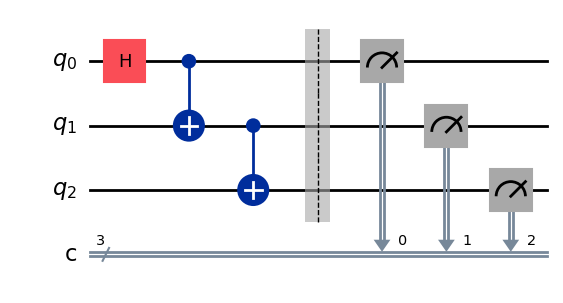

In [17]:
from qiskit import QuantumCircuit

# GHZ para 3 qubits
ghz = QuantumCircuit(3, 3)
ghz.h(0)
ghz.cx(0, 1)
ghz.cx(1, 2)
ghz.barrier()
ghz.measure([0,1,2], [0,1,2])
ghz.draw('mpl')


Using backend: ibm_sherbrooke


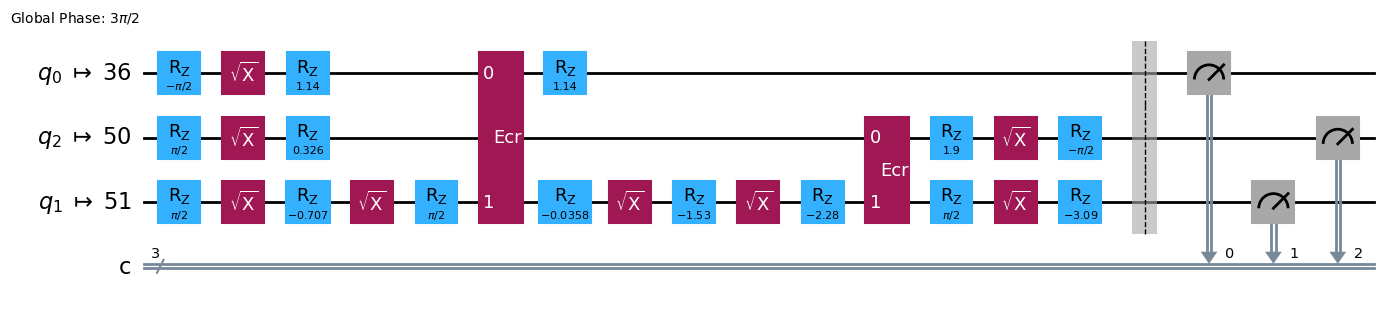

In [19]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import PassManager
from qiskit import transpile
#from qiskit.providers.fake_provider import FakeManila
from qiskit_ibm_runtime import QiskitRuntimeService


service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True)

print(f'Using backend: {backend.name}')



pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(ghz)
 
isa_circuit.draw("mpl", idle_wires=False)



Approach #2: Optimize the tangent vector:



In [ ]:

def d_FS(psi : Qobj, phi : Qobj) -> Qobj:
    return np.sqrt( 2 - 2 * np.abs(psi.dag() * phi) ) 


def psi_dot(psi_init : Qobj, psi_final : Qobj) -> Qobj:
    """
    Calcula la derivada del estado cuántico
    """
    theta = np.arccos(np.real(psi_init.dag() * psi_final))

    psi_t = (psi_final - np.cos(theta)*psi_init) / np.sin(theta)

    return psi_t



def cost_func_geodesic():
    psi_init = qt.tensor(s0, s0)  # Estado inicial
    psi_final = Bell2  # Estado final


    N = 2 #numero de qubits
    OP = [SX_qubit(N, 0), SX_qubit(N, 1), ECR(N, 0, 1), ECR(N, 1, 0), SX(N,0), SX(N,1)]
    n = 2
    
    num_iter = 300

    ideal_psidot = psi_dot(psi_init, psi_final)
    
    min_dist = 5
    for op in OP:
        psi_step = op * psi_init
        
        real_psidot = psi_dot(psi_init, psi_step)
        dist_psidots = d_FS(ideal_psidot, real_psidot)
        if dist_psidots < min_dist:
            min_dist = dist_psidots
            best_op = op
    
    new_psi = best_op * psi_init

    



    
        